Evaluation Metrics on Unseen Test Data:
             Metric  Value
           Test MSE   9.83
            Test R²   0.88
Regression Accuracy 79.87%


Index,Data Tag,Pre-load,RF Predicted Stress
1,attar2014investigating_plastic_a_1_sandstone,19.00,23.67
2,ali2023evaluation_DRA2_black,7.50,12.73
3,ali2023evaluation_DRA2_green,30.00,27.21
4,wang2024triaxial_DRA5_1,15.00,17.98
5,attar2014investigating_crack_b_2_tuff,3.50,4.11
6,attar2014investigating_crack_a_2_sandstone,2.00,2.62
7,attar2014investigating_linear_a_2_sandstone,8.00,9.47


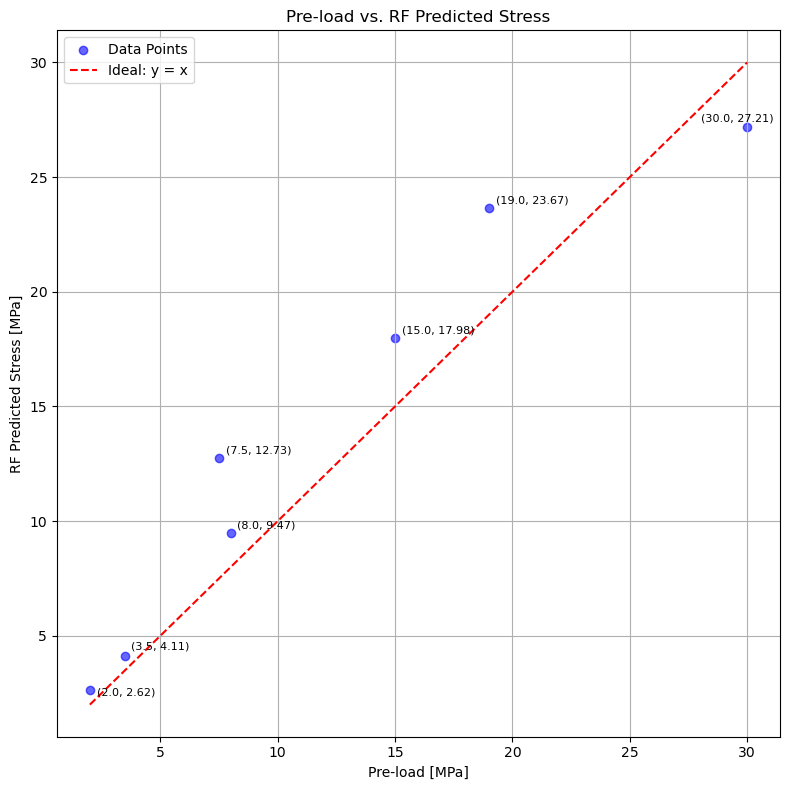

In [4]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

# ----------------------------
# User-defined Configuration
# ----------------------------
# Input the name of Random Forest model which will be used for prediction
model_name = "ExampleModelName"    #Do not include ".pkl"

# Input the name of the CSV file containing test data
filename = "testDataFile"    #Do not include ".csv"



# ----------------------------
# Load RandomForest Model
# ----------------------------
MODEL_FILE = f"{model_name}.pkl"
with open(MODEL_FILE, "rb") as f:
    model_data = pickle.load(f)

best_rf = model_data["model"]
scaler = model_data["scaler"]
PREDICTORS = model_data["predictors"]
TARGET = model_data["target"]


# ----------------------------
# Load and Preprocess Test Data
# ----------------------------
TEST_DATA_FILE = f"{filename}.csv"
test_data = pd.read_csv(TEST_DATA_FILE)
test_data = test_data.ffill()
# Shuffle the test data (optional)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Apply the saved scaler to the predictor columns.
test_data[PREDICTORS] = scaler.transform(test_data[PREDICTORS])
test_x = test_data[PREDICTORS]
test_y = test_data[TARGET]
data_tags = test_data["dataTag"]


# ----------------------------
# Evaluation Metrics
# ----------------------------
def regression_accuracy(actual, predicted):
    """
    Compute regression accuracy as the mean of (min(actual, predicted)/max(actual, predicted))*100.
    """
    accs = []
    for a, p in zip(actual, predicted):
        if a == 0 and p == 0:
            acc = 100
        elif a == 0:
            acc = 0
        else:
            acc = (min(a, p) / max(a, p)) * 100
        accs.append(acc)
    return np.mean(accs)


# ----------------------------
# Functions plotting results
# ----------------------------
def create_table(data_tags, preLoad, predicted, title="Model Predictions on Unseen Test Data"):
    """
    Creates and returns a styled table with columns: Index, Data Tag, Pre-load, and RF Predicted Stress.
    """
    if not (len(data_tags) == len(preLoad) == len(predicted)):
        raise ValueError("All input lists must have the same length.")
    indices = list(range(1, len(data_tags) + 1))
    data_dict = {
        "Index": indices,
        "Data Tag": data_tags,
        "Pre-load": preLoad,
        "RF Predicted Stress": predicted,
    }
    df = pd.DataFrame(data_dict)
    styled_table = df.style.hide(axis="index").set_caption(title).format({
        "Pre-load": "{:.2f}",
        "RF Predicted Stress": "{:.2f}"
    })
    return styled_table


def plot_preLoad_vs_prediction(preLoad, predicted, title="Pre-load vs. RF Predicted Stress"):
    """
    Plots a scatter plot of pre-load vs. RandomForest predicted stress and overlays an ideal y=x line.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(preLoad, predicted, color='blue', alpha=0.6, label='Data Points')
    
    # Create text annotations for each point.
    texts = []
    for p, a in zip(preLoad, predicted):
        texts.append(plt.text(p, a, f'({p}, {round(a,2)})', fontsize=8, ha='left', va='bottom'))
    adjust_text(texts, verbose=0)
    
    # Draw the y=x line.
    min_val = min(min(preLoad), min(predicted))
    max_val = max(max(preLoad), max(predicted))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: y = x')
    
    plt.xlabel("Pre-load [MPa]")
    plt.ylabel("RF Predicted Stress [MPa]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ----------------------------
# Run Model on Test Data and Evaluate
# ----------------------------
test_preds = best_rf.predict(test_x)
test_mse_val = mean_squared_error(test_y, test_preds)
test_r2_val = r2_score(test_y, test_preds)
test_reg_acc = regression_accuracy(test_y, test_preds)


# Display evaluation metrics in a table
metrics_df = pd.DataFrame({
    "Metric": ["Test MSE", "Test R²", "Regression Accuracy"],
    "Value": [f"{test_mse_val:.2f}", f"{test_r2_val:.2f}", f"{test_reg_acc:.2f}%"]
})
print("Evaluation Metrics on Unseen Test Data:")
print(metrics_df.to_string(index=False))

# Display pre-load vs. ANN predicted stress.
table = create_table(data_tags, test_data[TARGET], test_preds, title="RandomForest Model Predictions on Test Data")
# The following display command works within Jupyter Notebook environments.
try:
    from IPython.display import display
    display(table)
except ImportError:
    print(table.data)  # For non-notebook environments, simply print the DataFrame.

plot_preLoad_vs_prediction(test_data[TARGET].values, test_preds)